In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Setup
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
# warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

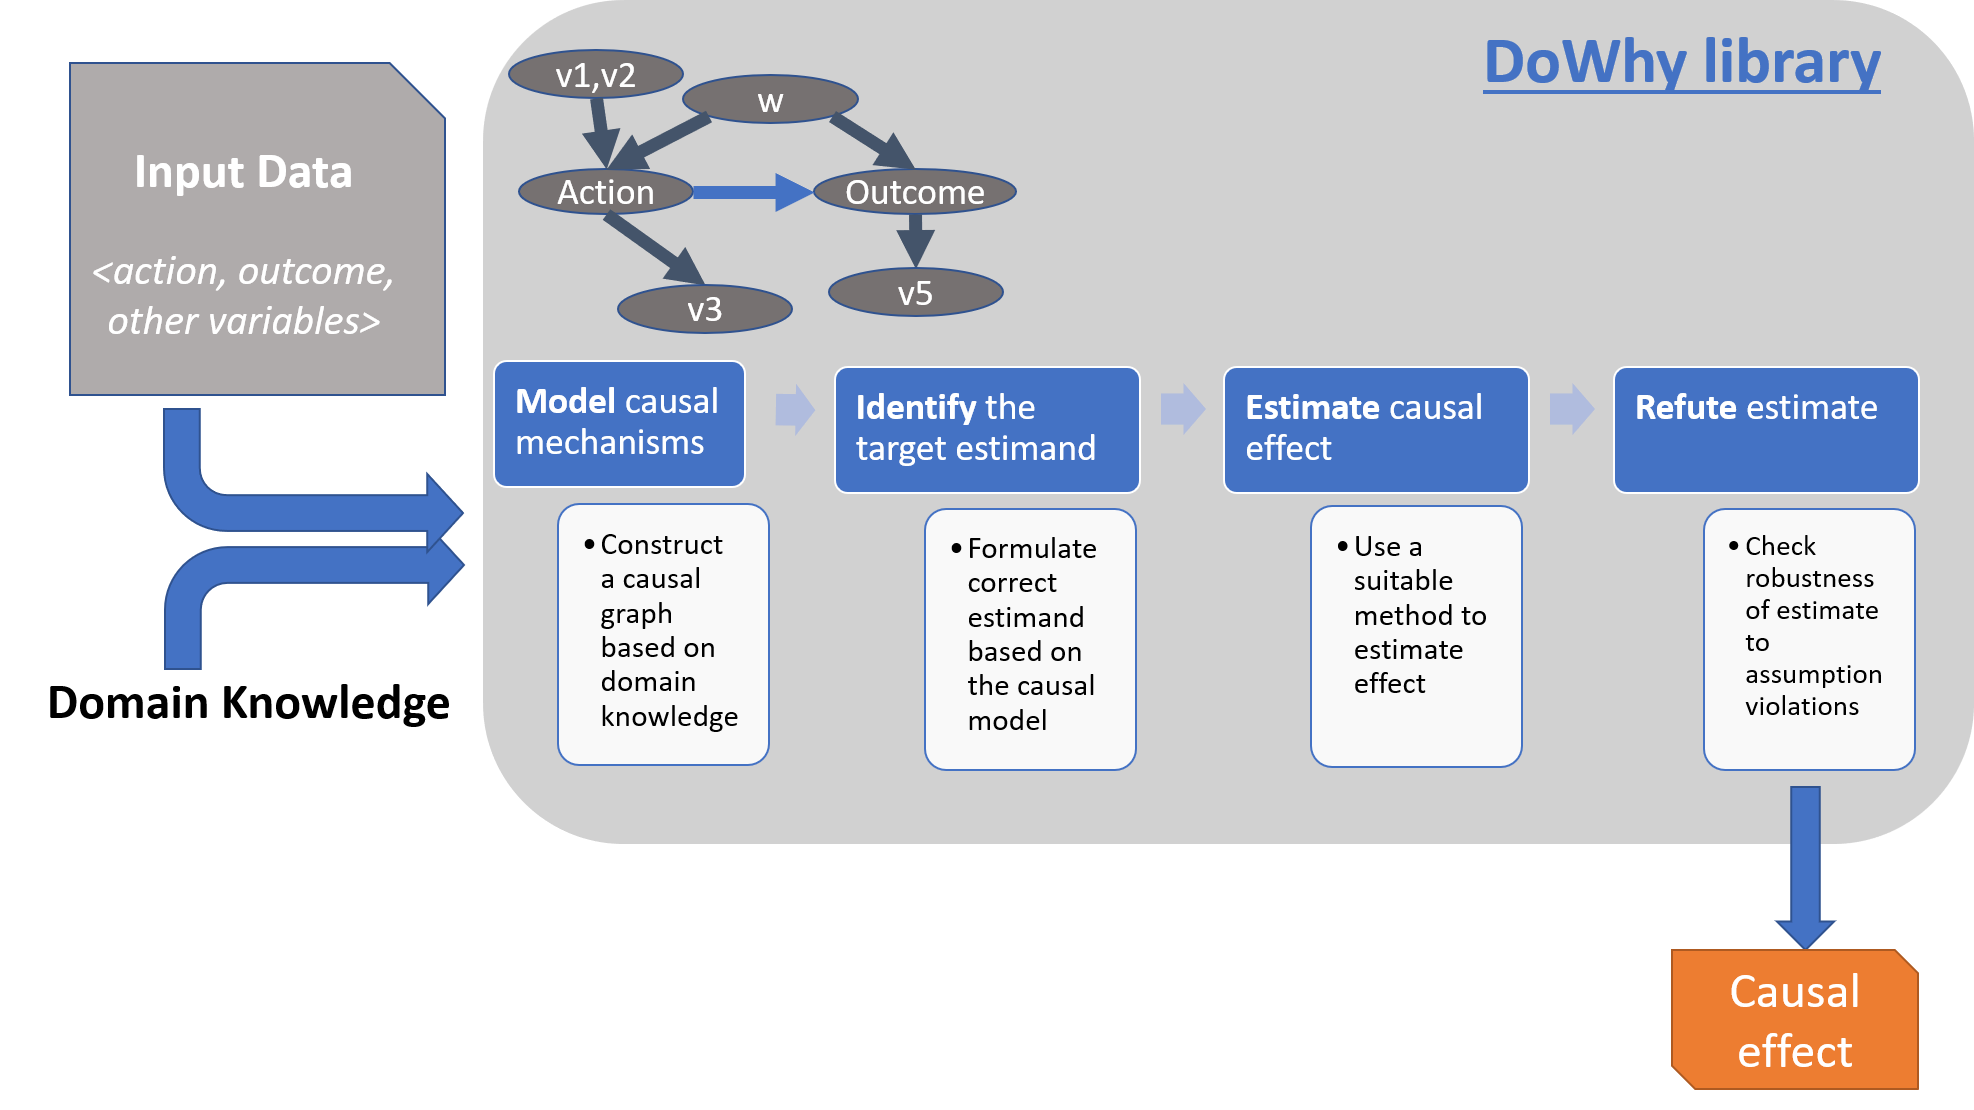

# Example 1 - Hotel Booking Cancellation

## Import dataset and Feature Engineering

In [3]:
### Load data
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
### Data engineering according to the blog post
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


In [5]:
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


## Model

In [6]:
### casual graph from the blog post
causal_graph = """
digraph {
age[label="Age"];
experience[label="Experience"];
income[label="Income"];
family[label="Family"];
ccavg[label="Credit Card Spending"];
edu[label="Education"];
mortgage[label="Mortgage"];
personal_loan[label="Personal Loan"];
securities_account[label="Securities Account"];
cd_account[label="CD Account"];
online[label="Online"];
credit_card[label="Credit Card"];
age -> experience; age -> income; family -> income; age -> ccavg; 
age -> edu; age -> mortgage; age -> personal_loan; age -> family; 
experience -> income; experience -> personal_loan; 
income -> ccavg; income -> mortgage; income -> personal_loan; income -> securities_account;
income -> cd_account; income -> credit_card; 
family -> ccavg; family -> personal_loan;
ccavg -> personal_loan; edu -> personal_loan;
edu -> income; 
mortgage, securities_account, cd_account, online, credit_card -> personal_loan
}
"""

In [1]:
### create causal model and visualize causal graph
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='edu',
        outcome='personal_loan')
model.view_model()

NameError: name 'dowhy' is not defined

## Identify

In [8]:
### Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|required_car_parking_spaces
d[different_room_assigned]                                                    

                                                                              
,total_of_special_requests,hotel,previous_bookings_not_canceled,booking_change
                                                                              

                                                                              
s,lead_time,market_segment,meal,is_repeated_guest,total_stay,country,guests,da
                                                                              

                    
ys_in_waiting_list))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_ass

## Estimate

In [9]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|required_car_parking_spaces
d[different_room_assigned]                                                    

                                                                              
,total_of_special_requests,hotel,previous_bookings_not_canceled,booking_change
                                                                              

                                                                              
s,lead_time,market_segment,meal,is_repeated_guest,total_stay,country,guests,da
                                                                              

                    
ys_in_waiting_list))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→i

## Refute

### Radom Common Cause

In [10]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.32557854124922087
New effect:-0.3207031480718362



After adding a random common cause to the model, the estimated effect remains the same. Estimated effect is robust

### Placebo Treatment Refute

In [11]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.32557854124922087
New effect:-0.00019483428652613998
p value:0.49



By setting a random node as treatment, the effect is close to 0. Estimated effect is robust

### Data Subset Refuter

In [12]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.32557854124922087
New effect:-0.3228347159866714
p value:0.15



The result is similar across different data subset.

# Lalonde Dataset

## Load Data

In [77]:
lalonde=pd.read_csv("lalonde.csv")
lalonde=lalonde.drop(columns = ["Unnamed: 0"])
lalonde["treat"] = lalonde["treat"]>0
lalonde.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,True
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,True
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,True
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,True
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,True


## Model

In [78]:
model=dowhy.CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))

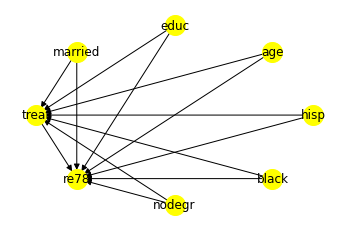

In [79]:
model.view_model()

## Identify

In [80]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(Expectation(re78|nodegr,black,educ,hisp,age,married))
d[treat]                                                      
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,nodegr,black,educ,hisp,age,married,U) = P(re78|treat,nodegr,black,educ,hisp,age,married)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Estimate

In [81]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 1614.1678218903717


## Refute

In [82]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.32557854124922087
New effect:-0.3207031480718362



# Twins Dataset

## Load Data and Feature Engineering

In [83]:
#The covariates data has 46 features
x = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv")

#The outcome data contains mortality of the lighter and heavier twin
y = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_Y_3years_samesex.csv")

#The treatment data contains weight in grams of both the twins
t = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_T_3years_samesex.csv")

In [84]:

#_0 denotes features specific to the lighter twin and _1 denotes features specific to the heavier twin
lighter_columns = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6', 'infant_id_0',
       'dlivord_min', 'dtotord_min', 'bord_0',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
heavier_columns = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6',
       'infant_id_1', 'dlivord_min', 'dtotord_min', 'bord_1',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

In [85]:
data = []

for i in range(len(t.values)):

    #select only if both <=2kg
    if t.iloc[i].values[1]>=2000 or t.iloc[i].values[2]>=2000:
        continue

    this_instance_lighter = list(x.iloc[i][lighter_columns].values)
    this_instance_heavier = list(x.iloc[i][heavier_columns].values)

    #adding weight
    this_instance_lighter.append(t.iloc[i].values[1])
    this_instance_heavier.append(t.iloc[i].values[2])

    #adding treatment, is_heavier
    this_instance_lighter.append(0)
    this_instance_heavier.append(1)

    #adding the outcome
    this_instance_lighter.append(y.iloc[i].values[1])
    this_instance_heavier.append(y.iloc[i].values[2])
    data.append(this_instance_lighter)
    data.append(this_instance_heavier)

In [86]:
cols = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6',
       'infant_id', 'dlivord_min', 'dtotord_min', 'bord',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg','wt','treatment','outcome']
df = pd.DataFrame(columns=cols,data=data)
df.head()

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,...,infant_id,dlivord_min,dtotord_min,bord,brstate_reg,stoccfipb_reg,mplbir_reg,wt,treatment,outcome
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,35.0,3.0,3.0,2.0,5.0,5.0,5.0,936.0,0,0.0
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,34.0,3.0,3.0,1.0,5.0,5.0,5.0,1006.0,1,0.0
2,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,...,47.0,NaN,NaN,NaN,5.0,5.0,5.0,737.0,0,0.0
3,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,...,46.0,NaN,NaN,NaN,5.0,5.0,5.0,850.0,1,1.0
4,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,...,52.0,1.0,1.0,1.0,5.0,5.0,5.0,1830.0,0,0.0


In [87]:
df = df.astype({"treatment":'bool'}, copy=False) #explicitly assigning treatment column as boolean

df.fillna(value=df.mean(),inplace=True)    #filling the missing values
df.fillna(value=df.mode().loc[0],inplace=True)

data_1 = df[df["treatment"]==1]
data_0 = df[df["treatment"]==0]
print(np.mean(data_1["outcome"]))
print(np.mean(data_0["outcome"]))
print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))

0.16421895861148197
0.1894192256341789
ATE -0.025200267022696926


## Model

In [88]:
#The causal model has "treatment = is_heavier", "outcome = mortality" and "gestat10 = gestational weeks before birth"
model=dowhy.CausalModel(
        data = df,
        treatment='treatment',
        outcome='outcome',
        common_causes='gestat10'
        )

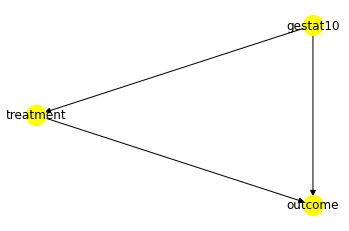

In [89]:
model.view_model()

## Identify

In [90]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
────────────(Expectation(outcome|gestat10))
d[treatment]                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,gestat10,U) = P(outcome|treatment,gestat10)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Estimate

### Linear Regression

In [91]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)
print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
────────────(Expectation(outcome|gestat10))
d[treatment]                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,gestat10,U) = P(outcome|treatment,gestat10)

## Realized estimand
b: outcome~treatment+gestat10
Target units: ate

## Estimate
Mean value: -0.02520026702265704
p-value: [7.18902894e-08]

ATE -0.025200267022696926
Causal Estimate is -0.02520026702265704


### Propensity Score Matching

In [92]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))

Causal Estimate is -0.012600133511348465
ATE -0.025200267022696926


## Refute

### Radom Common Cause

In [93]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.012600133511348465
New effect:-0.025492323097463285



### Placebo Treatment Refute

In [94]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.012600133511348465
New effect:0.005039218958611481
p value:0.45



By setting a random node as treatment, the effect is close to 0. Estimated effect is robust

### Data Subset Refuter

In [95]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.012600133511348465
New effect:-0.03663972045478252
p value:0.44999999999999996



Questions:
1. The p value in the refuter result
2. How good/bad is the refuter result for the last example? Ex. Placebo Treatment gives higher effects than the treatment 
